In [1]:
# All code is written in Python 3.11.5, and the necessary libraries are imported below.
# Data Handling and Manipulation Libraries
import numpy as np
import pandas as pd
# Data Visualization Libraries
import matplotlib.pyplot as plt
import pyLDAvis # For visualizing the output of topic models like LDA (Latent Dirichlet Allocation)
import pyLDAvis.gensim_models as gensimvis  # For integrating gensim LDA models with pyLDAvis for visualization
# Natural Language Processing and Topic Modeling Libraries
import gensim  # For topic modeling and other natural language processing tasks
from gensim import corpora  # For creating and working with a corpus 
from gensim.models import CoherenceModel  # For evaluating the coherence of topics in a topic model
from gensim.matutils import Sparse2Corpus  # For converting Scikit-learn sparse matrices to Gensim corpora
from gensim.models.ldamodel import LdaModel  # For creating and working with LDA models using Gensim
# Machine Learning Libraries
from sklearn.feature_extraction.text import CountVectorizer  # For converting a collection of text documents to a matrix of token counts
from sklearn.decomposition import LatentDirichletAllocation  # For performing LDA on a dataset
# Utility Libraries
from tqdm import tqdm  # For displaying progress bars during long-running operations

In [3]:
df=pd.read_csv('/Users/gulyagurbanova/Desktop/uom/extended research/data/processed_reviews_second.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167567 entries, 0 to 167566
Data columns (total 21 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   listing_id                      167567 non-null  int64  
 1   id                              167567 non-null  int64  
 2   date                            167567 non-null  object 
 3   reviewer_id                     167567 non-null  int64  
 4   comments                        167563 non-null  object 
 5   Year                            167567 non-null  int64  
 6   Lang                            167567 non-null  object 
 7   host_name                       167567 non-null  object 
 8   neighbourhood_cleansed          167567 non-null  object 
 9   room_type                       167567 non-null  object 
 10  price                           167567 non-null  object 
 11  minimum_nights                  167567 non-null  int64  
 12  number_of_review

In [7]:
# Dropping the rows where the 'comments' column is empty
df = df.dropna(subset=['comments'])

# Vectorizin text data into a document-term matrix (DTM), where each row represents a document and each column represents a word's frequency in that document.
vectorizer = CountVectorizer(max_df=0.95, min_df=2)
dtm = vectorizer.fit_transform(df['comments'])

# Converting the document-term matrix to a gensim corpus. This conversion allows the document-term matrix to be used with Gensim's tools, particularly for topic modeling.
corpus = gensim.matutils.Sparse2Corpus(dtm, documents_columns=False)

# Fitting LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [12]:
# Create a dictionary mapping from word ids to words. This dictionary will be used later to map the word IDs from the document-term matrix back to the actual words
id2word = {v: k for k, v in vectorizer.vocabulary_.items()}

# Defining a function to compute coherence values for different numbers of topics. This function helps evaluate the quality of the topics generated by the LDA model.
# The function iterates over a range of topic numbers, fitting an LDA model for each number and computing the coherence score.
def compute_coherence_values(dtm, vectorizer, start=2, limit=10, step=1):
    coherence_values = []
    model_list = []
    feature_names = vectorizer.get_feature_names_out()  # Use get_feature_names_out()

    for num_topics in tqdm(range(start, limit, step)):
        model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        model.fit(dtm)
        model_list.append(model)

        topics = [[feature_names[i] for i in topic.argsort()[:-15 - 1:-1]] for topic in model.components_]

        # Convert the topics to the gensim format
        texts = [[id2word[i] for i in doc.nonzero()[1]] for doc in dtm]
        dictionary = corpora.Dictionary(texts)
        coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values

# Computing coherence values for different numbers of topics
model_list, coherence_values = compute_coherence_values(dtm, vectorizer, start=5, limit=40, step=1)

100%|██████████| 35/35 [2:08:15<00:00, 219.88s/it]  


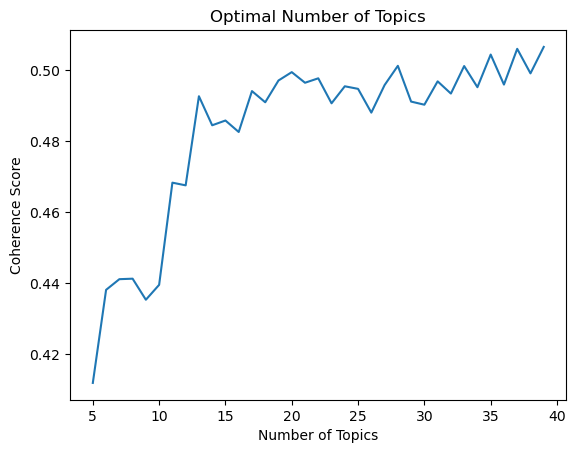

In [13]:
# Plotting coherence values
x = range(5, 40, 1)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics")
plt.show()

In [23]:
# Enabling pyLDAvis in the notebook. This allows interactive visualizations to be displayed directly in the notebook
pyLDAvis.enable_notebook()

# Creating a gensim dictionary from the corpus. The dictionary maps word IDs to words, which is used by the LDA model for topic modeling
dictionary = corpora.Dictionary.from_corpus(corpus, id2word=id2word)

# Function to build LDA model and display results using pyLDAvis
def build_lda_and_display(num_topics):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10)

    # Visualize the topics
    vis = gensimvis.prepare(lda_model, corpus, dictionary)
    pyLDAvis.display(vis)
    
    return lda_model, vis

# List to store the visualizations
visualizations = []

# Generating and visualizing LDA models for different numbers of topics
for num_topics in [13, 28]:
    print(f"Building LDA model with {num_topics} topics...\n")
    lda_model, vis = build_lda_and_display(num_topics)
    visualizations.append(vis)
    print(f"LDA Model with {num_topics} topics completed.\n")

Building LDA model with 13 topics...

LDA Model with 13 topics completed.

Building LDA model with 28 topics...

LDA Model with 28 topics completed.



In [24]:
# Manually display the visualizations
# Displaying the visualization for 13 topics
print("Displaying visualization for 13 topics:")
pyLDAvis.display(visualizations[0])

Displaying visualization for 13 topics:


In [25]:
# Displaying the visualization for 28 topics
print("Displaying visualization for 28 topics:")
pyLDAvis.display(visualizations[1])

Displaying visualization for 28 topics:
